In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

import apertls
from matplotlib.colors import LogNorm

In [2]:
# This script takes around 8 minutes on a modern CPU (80s preparation+interpolation, 400s tracking)
context = xo.ContextCpu()

beam = 1
plane = 'DNeg'#'DPpos'

num_particles  = 500
sweep          = 3500
sweep          = -abs(sweep) if plane == 'DPpos' else abs(sweep)
#num_turns      = int(20*abs(sweep))
num_turns=6000

In [3]:
nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [4]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')

#setting all cavities to 200 (even 800 cavities) because rf sweep not implemented
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)
for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180

line['acl.31735'].voltage = 0

#Needed to resolve the driftslice parent issues
line.build_tracker()
line.discard_tracker()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
line.get_s_position(['bpcn.12508.a_aper','bpcn.12508.b_aper'])

[np.float64(799.5902), np.float64(799.825)]

In [6]:
theta = np.atan(5.3/809)
L1 = 34e-3
L2 = 21e-3
L3 = 754e-3
h_tot = 5.3e-3

x1 = L1/np.cos(theta)
x2 = L2/np.cos(theta)
x3 = L3/np.cos(theta)

print(np.sin(theta)*(x1+x2+x3), h_tot)

x_tot = x1+x2+x3
w_steel = x1/x_tot
w_air = (x2+x3)/x_tot

print(w_steel, w_air)

0.0053 0.0053
0.04202719406674908 0.9579728059332508


In [7]:
d_steel_air = x2+x3

X_Be = 35.28e-2
X_air = 303.9
X_Fe = 1.757e-2
X_C = 19.32e-2
X_steel = (0.02/X_C + 0.98/X_Fe)**(-1)
X_steel_air = (w_steel/X_steel + w_air/X_air)**(-1)

d_Be = X_Be/X_steel_air * d_steel_air #shorter than d_steel_air so we can keep angle theta and stop collimator before end of VCAK

In [8]:
line.discard_tracker()
#collimator jaw positions:
ap_vebb_x = 0.0645
jaw_ru = -ap_vebb_x
jaw_rd = -ap_vebb_x - h_tot
jaw_lu = ap_vebb_x
jaw_ld = ap_vebb_x - h_tot
L_coll = d_Be

coll_12501 = xc.EverestCollimator(length=L_coll, material=xc.materials.Beryllium, jaw_RU=jaw_ru, jaw_RD=jaw_rd, jaw_LU=jaw_lu, jaw_LD=jaw_ld)
coll_61101 = xc.EverestCollimator(length=L_coll, material=xc.materials.Beryllium, jaw_RU=jaw_ru, jaw_RD=jaw_rd, jaw_LU=jaw_lu, jaw_LD=jaw_ld)
name_colls = ['vcak.12501_coll', 'vcak.61101_coll']
s_colls = [line.get_s_position('vebb.12490.b_aper'), line.get_s_position('vebb.61090.b_aper')]

names_vcak_apers_to_remove = ['vcak.12501.a_aper', 'vcak.12501.b_aper', 'vcak.61101.a_aper', 'vcak.61101.b_aper']
# for name in names_vcak_apers_to_remove:
#     line.remove(name)

line.collimators.install(names=name_colls, elements=[coll_12501, coll_61101], at_s=s_colls)

Slicing line:   0%|          | 0/75280 [00:00<?, ?it/s]

In [9]:
#optics
tw = line.twiss()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [10]:
#particles
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='25'))

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004873
--> Emittance: 0.34209413293702573
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [11]:
#rf sweep
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

The current frequency is 200000000.0Hz, adding 0.5833333333333334Hz per turn until 200003500.0 (for 6000 turns).
This sweep will move the center of the bucket with Δδ = -0.009734169779084362 (-1.334655851427876 buckets).


In [12]:
#tracking
line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

All particles lost at turn 5963, stopped sweep at 2783.082936Hz.
Done sweeping RF in 5704.5s.


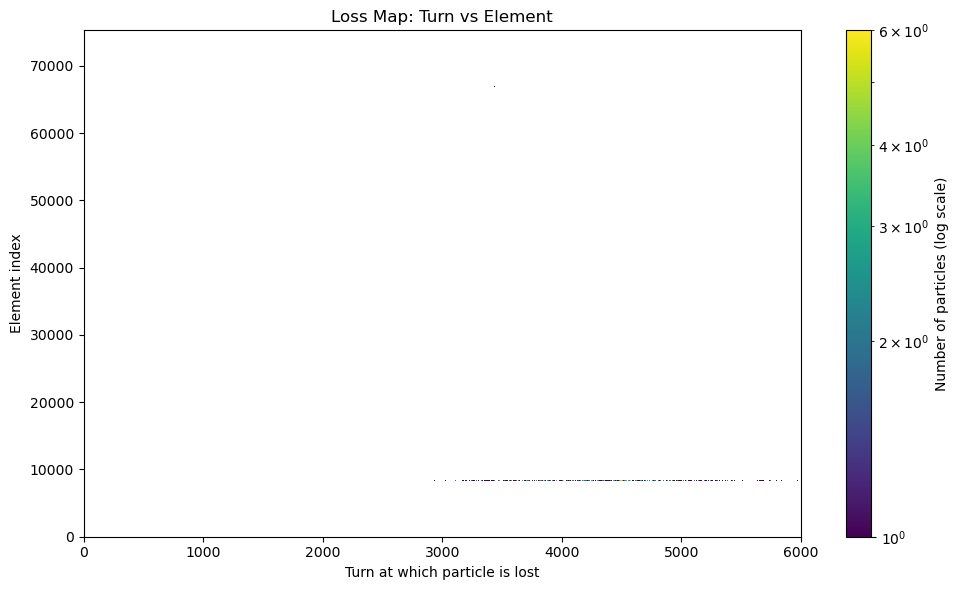

In [13]:
#Plot
turn_bins_resolution = 1000
turn_min, turn_max = 0, num_turns
turn_bins = np.linspace(turn_min, turn_max, turn_bins_resolution + 1)

element_bin_resolution = 1000
element_min, element_max = 0, len(line.element_names)
element_bins = np.linspace(element_min, element_max, element_bin_resolution + 1)

hist2d, element_edges, turn_edges = np.histogram2d(
    part.at_element[part.state<=0], part.at_turn[part.state<=0],
    bins=[element_bins, turn_bins]
)

plt.figure(figsize=(10, 6))
plt.imshow(hist2d, aspect='auto', interpolation='nearest',
           extent=[turn_bins[0], turn_bins[-1], element_bins[0], element_bins[-1]],
           origin='lower', norm=LogNorm())

plt.colorbar(label='Number of particles (log scale)')
plt.xlabel('Turn at which particle is lost')
plt.ylabel('Element index')
plt.title('Loss Map: Turn vs Element')

plt.tight_layout()
plt.show()